In [1]:
import time
import rlapy as rla
import numpy as np
import scipy.linalg as la
from notebooks.least_squares.helpers import make_demo_helper
from matplotlib import pyplot as plt

This notebook shows a procedural API for an overdetermined least squares driver. The driver accepts data (A, b), a target tolerance "tol", iteration limit "iter_lim", and a random seed.

The driver checks the aspect ratio of the input and decides if it should fall back on LAPACK or use one of three randomized methods:
 * The first randomized method has no accuracy guarantees, and is only called if the user specifies an iteration limit of 1.
 * The latter two randomized methods can produce solutions of any accuracy. They are called "sketch-and-precondition" methods because they use randomization to find a preconditioner and then call a deterministic iterative solver.

In [2]:
def rlstsq(A, b, tol=1e-12, iter_lim=50, mode='qr', rng=None):
    m, n = A.shape
    driver = 'gelsy' if mode == 'qr' else 'gelsd'
    sampling_factor = 4
    if m / n < 2 * sampling_factor:
        # No meaningful savings from a randomized method
        # Call LAPACK
        full_result = la.lstsq(A, b, lapack_driver=driver)
        return full_result[0]
    else:
        if iter_lim <= 1:
            # Sketch and solve
            iter_lim = 1
            tol = np.NaN
            alg = rla.SAS1(rla.sjlt_operator, sampling_factor, driver)
        elif mode == 'qr':
            # Sketch and precondition (LSQR iterative solver)
            # Initializes LSQR at the output of "sketch and solve"
            # Current implementation needs A to be full rank
            alg = rla.SAP1(rla.sjlt_operator, sampling_factor)
        else:
            # Sketch and precondition (LSQR iterative solver)
            # Initializes LSQR at the zero vector
            # Uses SVD; A can be rank deficient
            alg = rla.SAP2(rla.sjlt_operator, sampling_factor, False)
        x = alg.exec(A, b, tol, iter_lim, rng)
        return x


## Generate and visualize initial problem data

The code below generates least squares problem data (A, b) where
  * We have complete control over the dimensions and singular values of A.
  * We can control the proportion of b which lays in the range of A, as measured by ||UU'b|| / ||b|| where U is an orthonormal basis for range(A).
  
For the purposes of this notebook, we represent least squares problem data through a helper data structure. Using such a data structure makes it cheaper to run experiments.

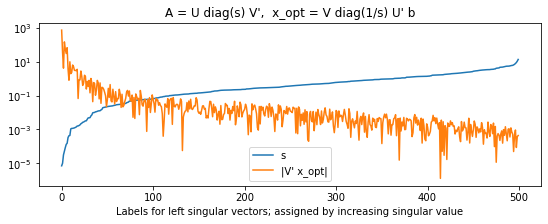

In [3]:
#TODO: fix this notebook. It's broken after I refactored "ols_data" in
#   helpers.py to become "make_demo_helper".# Define a "parent" random number generator
#    Use this to define initial problem data.
#    Use this to choose random seeds later on.
parent_rng = np.random.default_rng(203948574)

# Dimensions of A
m, n = int(1e5), int(5e2)

# Singular values of A
#    You can set this however you like.
#    If spectrum.size < n, then you're making a rank-deficient matrix.
spectrum = parent_rng.normal(loc=0.0, scale=1, size=n)**2
spectrum += 1e-6

# The proportion of b that lays in range(A).
#    This is always in [0, 1].
#    prop_range = 1 means A x = b is consistent.
prop_range = 0.1

# Make a LSDemoHelper object.
#    We sample the left and right singular vectors of A in a rotationally-invariant way.
#    This object stores (A, b), the SVD of A, and the solution to min || A x - b||_2.
demo_helper = make_demo_helper(m, n, spectrum, prop_range, parent_rng)

# For improved readability, load some variables directly into the workspace.
A = demo_helper.A
b = demo_helper.b
x_opt = demo_helper.x_opt

# Visualize
indices = np.argsort(spectrum)
fig = plt.figure(figsize=(9, 3))
plt.title("A = U diag(s) V',  x_opt = V diag(1/s) U' b")
plt.semilogy(np.arange(n), spectrum[indices], label='s')
y_opt = demo_helper.Vt @ x_opt
plt.semilogy(np.arange(n), np.abs(y_opt[indices]), label="|V' x_opt|")
plt.xlabel('Labels for left singular vectors; assigned by increasing singular value')
plt.legend()
plt.show()

Components of the vector |V' x_opt| give the "energy" of the optimal solution in the coordinate system induced by A's SVD. 

## Experiment: iterations quickly improve solution accuracy.

Let A = U diag(s) V' be the SVD of A and x_opt = argmin{ || A x - b || : x in R^n} be the solution to the least squares problem defined by (A, b). Here we show two applications of the provided randomized least squares driver.

Our first call to the least squares driver carries out an algorithm called sketch-and-solve. It returns a solution with very low accuracy. The second call carries out sketch-and-precondition. It returns a solution near the target accuracy.

We measure solution accuracy with the following error metrics:
  * Relative residual error: ||UU'(b - Ax)|| / ||b - Ax||.
  * Relative solution error: ||x - x_opt|| / (1 + min(||x||, ||x_opt||)

Note that both of these metrics should be near zero at optimality. When b is in the range of A, numerical issues prevent us from reliably computing relative residual error.

In [4]:
seed = parent_rng.integers(low=0, high=int(1e10))

# Run "sketch and solve"
x = rlstsq(A, b, tol=1e-2, iter_lim=1, rng=seed)  # tolerance is ignored; could be np.NaN
r = b - A @ x
r_proj = demo_helper.project_onto_range(r)
r_error = la.norm(r_proj) / la.norm(r)
x_error =  la.norm(x - x_opt) / (1 + min(la.norm(x), la.norm(x_opt)))
print('sketch-and-solve')
print(f"\tRelative residual error : {r_error}")
print(f"\tRelative solution error : {x_error}\n")

# Run "sketch and precondition"
x = rlstsq(A, b, tol=1e-12, iter_lim=50, rng=seed)
r = b - A @ x
r_proj = demo_helper.project_onto_range(r)
r_error = la.norm(r_proj) / la.norm(r)
x_error =  la.norm(x - x_opt) / (1 + min(la.norm(x), la.norm(x_opt)))
print('sketch-and-precondition')
print(f"\tRelative residual error : {r_error}")
print(f"\tRelative solution error : {x_error}")

sketch-and-solve
	Relative residual error : 0.505903466802338
	Relative solution error : 4.7266982870248695

sketch-and-precondition
	Relative residual error : 7.316631091817314e-12
	Relative solution error : 2.315485965479396e-10


Note that sketch-and-precondition returned a very accurate solution in at most 50 steps, despite the fact that the condition number of A is large (refer to the plot in the previous section). The rapid convergence is possible because the randomized method for finding the preconditioner is very effective.

## Experiment: effect of the angle between b and range(A).

Now we'll run more detailed experiments on sketch-and-precondition. Here's the setup for the experiments:
 * Use the same data matrix A from before.
 * Generate random vectors b, in a way where we have precise control over prop := || UU'b || / || b ||.
 * Sample "num_seeds" different vectors b for each value of "prop".
 * Record the same error metrics from the previous experiment.
 * Record the solver's wallclock runtime.

In [5]:
num_seeds = 3
seeds = parent_rng.integers(low=0, high=int(1e10), size=num_seeds)
props = np.logspace(-6, 0, num=20)  # 1e-6 to almost (but not including) 1.
props_vec = np.tile(props, num_seeds)
times_vec = np.zeros(props.size * seeds.size)
rerror_vec = np.zeros(props.size * seeds.size)
xerror_vec = np.zeros(props.size * seeds.size)
i = 0
for seed in seeds:
    for prop in props:
        # Generate the random vector b
        rng = np.random.default_rng(seed)
        b = demo_helper.resample_b(prop, rng)
        
        # Run the randomized algorithm
        tic = time.time()
        x = rlstsq(A, b, tol=1e-10, iter_lim=A.shape[0], rng=rng)
        toc = time.time()
        
        # Record runtime and compute error metrics
        times_vec[i] = toc - tic
        xerror_vec[i] = la.norm(x - demo_helper.x_opt) / (1 + min(la.norm(x), la.norm(demo_helper.x_opt)))
        r = b - A @ x
        r_proj = demo_helper.project_onto_range(r)
        rerror_vec[i] = la.norm(r_proj) / la.norm(r)
        i += 1

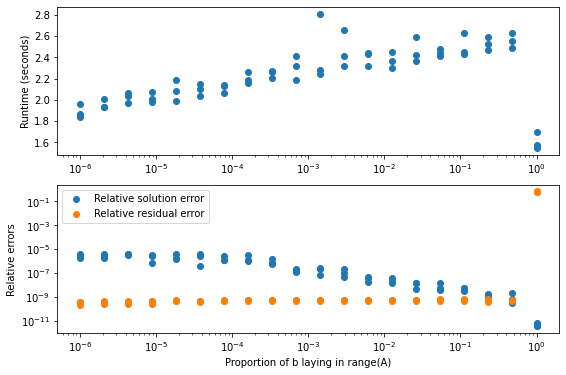

In [6]:
fig = plt.figure(figsize=(9, 6))

plt.subplot(2, 1, 1)
plt.scatter(props_vec, times_vec)
plt.ylabel('Runtime (seconds)')
plt.xscale('log')

plt.subplot(2, 1, 2)
plt.scatter(props_vec, xerror_vec, label='Relative solution error')
plt.scatter(props_vec, rerror_vec, label='Relative residual error')
plt.ylabel('Relative errors')
plt.xlabel('Proportion of b laying in range(A)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.show()

Let prop(b in A) := ||UU'b|| / ||b|| where U is the matrix of left singular vectors of A.
We interpret the plot above as follows:

 * An anomaly occurs when b is in the range of A (i.e., when prop(b in A) = 1).
     * In this case, sketch-and-solve is guaranteed to return the exact optimal solution. Since sketch-and-precondition initializes at the output of sketch-and-solve, it obtains the exact optimal solution after one iteration. Note how the relative solution error is near zero in this case.
     * Relative residual error cannot be accurately computed in this case, because it entails dividing by a number which is near zero.
 * Upper subplot: runtime increases slightly as prop(b in A) increases.
 * Lower subplot: relative solution errors decrease as prop(b in A) increases.
 * Lower subplot: the product of prop(b in A) and relative solution error is consistently near 1e-10.
 * Lower subplot: relative residual error is largely unaffected by prop(b in A).